# Test OCR Engine

Notebook để test module `OCREngine` từ `src/extraction/ocr_engine.py`.

## Features:
- Test EasyOCR và Tesseract OCR
- Read text từ image regions
- Classify chart labels (title, xlabel, ylabel, values)
- Visualize results


In [1]:
# Setup
import sys
from pathlib import Path

# Add project root to path
# Notebook is in bleh/notebooks/, so project_root should be bleh/ (one level up)
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Import modules
from src.extraction.ocr_engine import OCREngine
from src.preprocessing.image_utils import ImagePreprocessor
from src.preprocessing.chart_detector import ChartComponentDetector

print("Setup complete!")


Setup complete!


In [2]:
# Initialize OCR engine
try:
    ocr_engine = OCREngine(languages=['en', 'vi'], gpu=False)
    print("OCR Engine initialized successfully!")
    print(f"Available engines:")
    print(f"  - EasyOCR: {ocr_engine.easyocr_reader is not None}")
    
    # Check Tesseract availability
    try:
        import pytesseract
        print(f"  - Tesseract: {pytesseract is not None}")
    except ImportError:
        print(f"  - Tesseract: False (not installed)")
except Exception as e:
    print(f"Error initializing OCR engine: {e}")


Using CPU. Note: This module is much faster with a GPU.


OCR Engine initialized successfully!
Available engines:
  - EasyOCR: True
  - Tesseract: True


## Test 1: Read Text from Full Image using EasyOCR


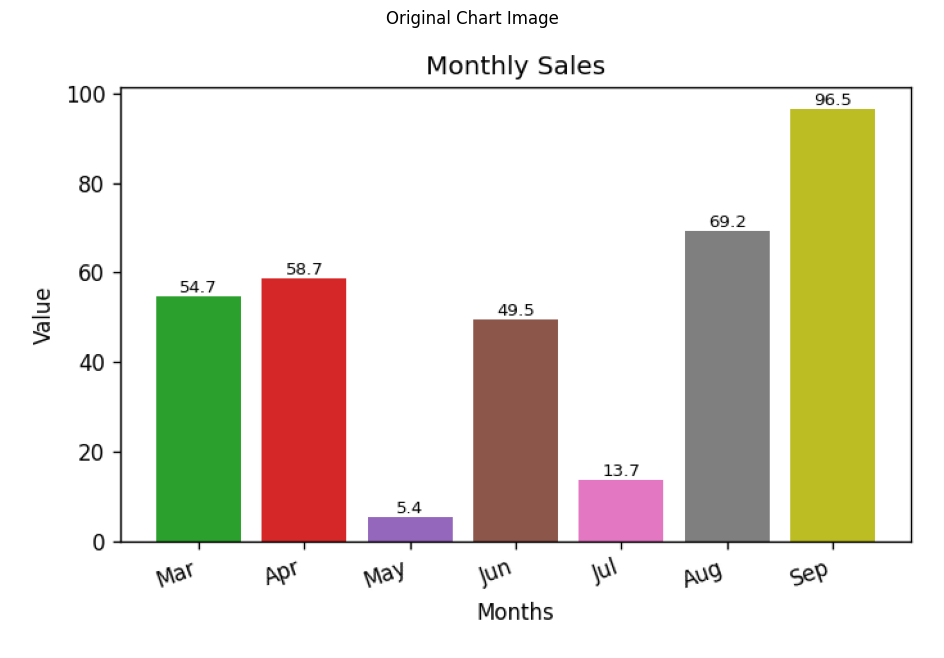

c:\Users\minht\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Found 14 text detections:
1. Text: 'Monthly Sales' | Confidence: 0.999
2. Text: '100' | Confidence: 0.615
3. Text: '80' | Confidence: 1.000
4. Text: '60' | Confidence: 0.999
5. Text: '40' | Confidence: 1.000
6. Text: '20' | Confidence: 1.000
7. Text: 'Apr' | Confidence: 0.992
8. Text: 'Jun' | Confidence: 0.997
9. Text: 'Jul' | Confidence: 0.984
10. Text: 'Months' | Confidence: 1.000
11. Text: 'Mar' | Confidence: 1.000
12. Text: 'May' | Confidence: 1.000
13. Text: 'Aug' | Confidence: 1.000
14. Text: 'Sep' | Confidence: 1.000


In [3]:
# Load a test image
image_path = project_root / "data" / "raw" / "bar_charts" / "chart_0001.png"

if image_path.exists():
    # Load and preprocess image
    preprocessor = ImagePreprocessor()
    image = preprocessor.load_image(str(image_path))
    
    # Display image
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title("Original Chart Image")
    plt.axis('off')
    plt.show()
    
    # Try reading text with EasyOCR
    try:
        detections = ocr_engine.read_text_easyocr(image, confidence_threshold=0.3)
        print(f"\nFound {len(detections)} text detections:")
        for i, det in enumerate(detections, 1):
            print(f"{i}. Text: '{det['text']}' | Confidence: {det['confidence']:.3f}")
    except Exception as e:
        print(f"Error reading text with EasyOCR: {e}")
else:
    print(f"Image not found: {image_path}")
    print("Please run generate_dataset.py first to create test images.")


## Test 2: Read Text from Specific Region


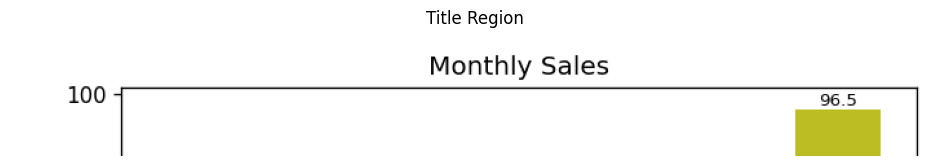


Text found in title region:
  - 'Monthly Sales' (confidence: 0.999)
  - '100' (confidence: 0.615)


In [4]:
# Extract a specific region (e.g., title area)
if image_path.exists():
    # Load image
    preprocessor = ImagePreprocessor()
    image = preprocessor.load_image(str(image_path))
    
    h, w = image.shape[:2]
    
    # Extract title region (top 20% of image)
    title_region = image[0:int(h*0.2), :]
    
    # Display region
    plt.figure(figsize=(12, 3))
    plt.imshow(title_region)
    plt.title("Title Region")
    plt.axis('off')
    plt.show()
    
    # Read text from region
    try:
        detections = ocr_engine.read_text_easyocr(title_region, confidence_threshold=0.3)
        print(f"\nText found in title region:")
        for det in detections:
            print(f"  - '{det['text']}' (confidence: {det['confidence']:.3f})")
    except Exception as e:
        print(f"Error: {e}")


## Test 3: Compare EasyOCR vs Tesseract


In [5]:
# Compare both OCR methods
if image_path.exists():
    preprocessor = ImagePreprocessor()
    image = preprocessor.load_image(str(image_path))
    
    h, w = image.shape[:2]
    title_region = image[0:int(h*0.2), :]
    
    print("=== EasyOCR Results ===")
    try:
        easyocr_results = ocr_engine.read_text_easyocr(title_region, confidence_threshold=0.3)
        for det in easyocr_results:
            print(f"  - '{det['text']}' (conf: {det['confidence']:.3f})")
    except Exception as e:
        print(f"  Error: {e}")
    
    print("\n=== Tesseract Results ===")
    try:
        tesseract_results = ocr_engine.read_text_tesseract(title_region)
        for det in tesseract_results:
            print(f"  - '{det['text']}' (conf: {det['confidence']:.3f})")
    except Exception as e:
        print(f"  Error: {e}")


=== EasyOCR Results ===
  - 'Monthly Sales' (conf: 0.999)
  - '100' (conf: 0.615)

=== Tesseract Results ===
  - 'Monthly' (conf: 0.960)
  - 'Sales' (conf: 0.960)
  - '100' (conf: 0.960)
  - '|' (conf: 0.830)
  - '96.5' (conf: 0.870)


## Test 4: Detect Text Regions and Classify Labels


Detected 1 text regions


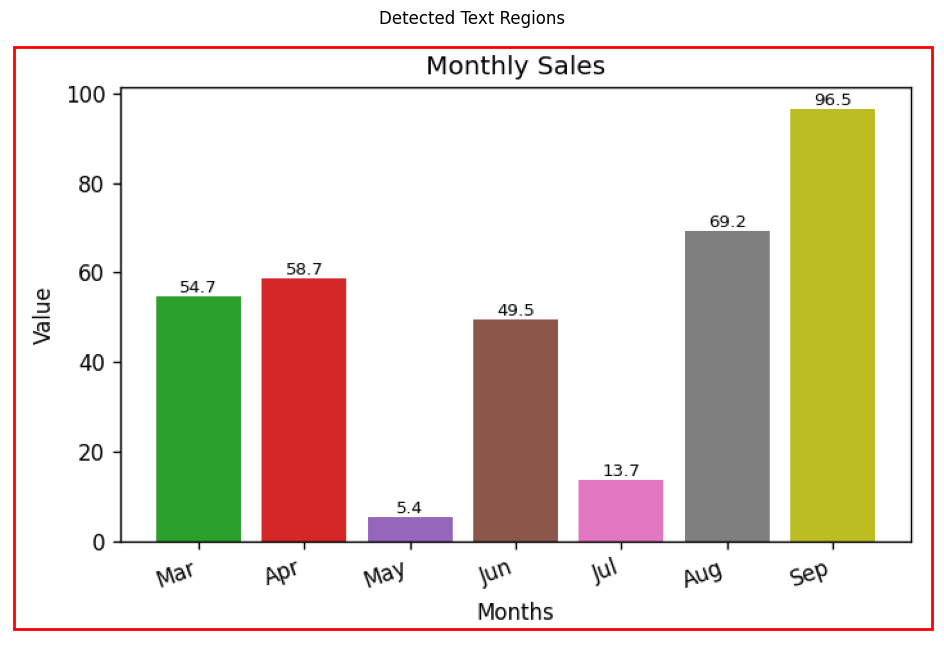


=== Classified Labels ===
Title: 
X-axis label: 
Y-axis label: 

Values (1 found):
  - 'Monthly Sales 100 40 20 Mar May Jun Jul Aug Sep Months Apr' at (360, 238)


In [6]:
# Full pipeline: Detect text regions and classify labels
if image_path.exists():
    # Load and preprocess
    preprocessor = ImagePreprocessor()
    image = preprocessor.load_image(str(image_path))
    
    # Detect text regions
    detector = ChartComponentDetector(preprocessor)
    text_regions = detector.detect_text_regions(image)
    
    print(f"Detected {len(text_regions)} text regions")
    
    # Display image with text regions
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image)
    
    for x, y, w, h in text_regions:
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
    ax.set_title("Detected Text Regions")
    ax.axis('off')
    plt.show()
    
    # Read and classify labels
    try:
        labels = ocr_engine.read_chart_labels(image, text_regions, ocr_method='easyocr')
        
        print("\n=== Classified Labels ===")
        print(f"Title: {labels['title']}")
        print(f"X-axis label: {labels['xlabel']}")
        print(f"Y-axis label: {labels['ylabel']}")
        print(f"\nValues ({len(labels['values'])} found):")
        for val in labels['values'][:10]:  # Show first 10
            print(f"  - '{val['text']}' at {val['position']}")
    except Exception as e:
        print(f"Error: {e}")


## Test 5: Visualize OCR Results on Chart


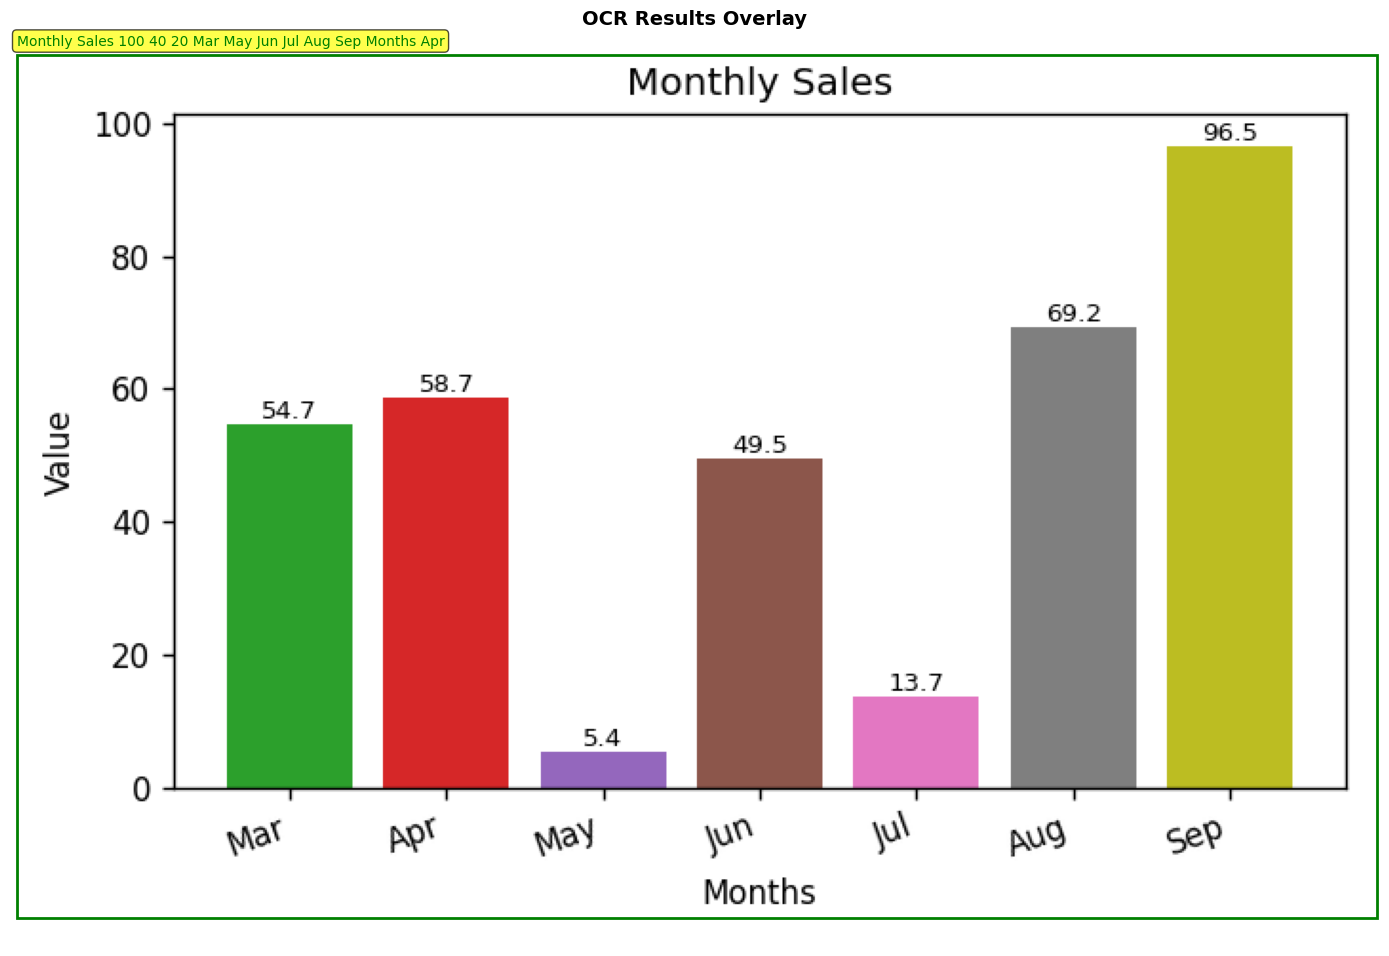

In [7]:
# Visualize OCR results on chart image
if image_path.exists():
    preprocessor = ImagePreprocessor()
    image = preprocessor.load_image(str(image_path))
    
    detector = ChartComponentDetector(preprocessor)
    text_regions = detector.detect_text_regions(image)
    
    # Read text from all regions
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.imshow(image)
    
    # Process each text region
    for x, y, w, h in text_regions:
        roi = image[y:y+h, x:x+w]
        try:
            detections = ocr_engine.read_text_easyocr(roi, confidence_threshold=0.3)
            if detections:
                # Draw bounding box
                rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='green', facecolor='none')
                ax.add_patch(rect)
                
                # Add text
                text = " ".join([d['text'] for d in detections])
                ax.text(x, y-5, text, fontsize=10, color='green', 
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
        except Exception as e:
            # Skip regions with errors
            pass
    
    ax.set_title("OCR Results Overlay", fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()


## Test 6: Process Multiple Charts


In [8]:
# Process multiple charts and compare results
chart_dir = project_root / "data" / "raw" / "bar_charts"
chart_files = sorted(chart_dir.glob("chart_*.png"))[:5]  # Test first 5 charts

if chart_files:
    preprocessor = ImagePreprocessor()
    detector = ChartComponentDetector(preprocessor)
    
    results = []
    
    for chart_path in chart_files:
        try:
            image = preprocessor.load_image(str(chart_path))
            text_regions = detector.detect_text_regions(image)
            labels = ocr_engine.read_chart_labels(image, text_regions, ocr_method='easyocr')
            
            results.append({
                'file': chart_path.name,
                'title': labels['title'],
                'xlabel': labels['xlabel'],
                'ylabel': labels['ylabel'],
                'num_values': len(labels['values'])
            })
        except Exception as e:
            print(f"Error processing {chart_path.name}: {e}")
    
    # Display results
    print("=== OCR Results Summary ===\n")
    for res in results:
        print(f"Chart: {res['file']}")
        print(f"  Title: {res['title'] or 'N/A'}")
        print(f"  X-label: {res['xlabel'] or 'N/A'}")
        print(f"  Y-label: {res['ylabel'] or 'N/A'}")
        print(f"  Values found: {res['num_values']}")
        print()
else:
    print("No chart files found. Please run generate_dataset.py first.")


=== OCR Results Summary ===

Chart: chart_0000.png
  Title: N/A
  X-label: 0oo Number of cases per 100,000 people
  Y-label: N/A
  Values found: 2

Chart: chart_0001.png
  Title: N/A
  X-label: N/A
  Y-label: N/A
  Values found: 1

Chart: chart_0002.png
  Title: N/A
  X-label: N/A
  Y-label: N/A
  Values found: 1

Chart: chart_0003.png
  Title: N/A
  X-label: N/A
  Y-label: N/A
  Values found: 1

Chart: chart_0004.png
  Title: N/A
  X-label: N/A
  Y-label: N/A
  Values found: 1

